# Exam - Sophia Wilson

I use my own library 'AdvAppStatFunctions' which contains many functions that I made in the course Applied Statistics and that I have extended i in this course. I will write at the particular problem if I use any code not made by myself.

In [1]:
# Standard libraires
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import scipy
from scipy import stats, interpolate
from scipy.optimize import minimize
import itertools
from iminuit import Minuit   
import copy
from tqdm.notebook import tqdm

# Nested fitting
import ultranest
from ultranest.plot import cornerplot
from ultranest.plot import PredictionBand


# External library
import sys  
from importlib import reload
sys.path.append('../') 
import AdvAppStatFunctions as aas

# setting for plotting
from matplotlib.patches import ConnectionPatch
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
plt.style.use('seaborn-white')
sns.set_style('white', {'legend.frameon':True})
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
sns.set_palette("colorblind")
color = sns.color_palette("colorblind")

from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, precision_score
from sklearn.metrics import roc_curve, auc

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

SaveFig = False
np.random.seed(18)

# Problem 2A

Many of the functions in this problem are inspiried by or identical to code made of Kimi Kreilgaard and can be found at 

https://github.com/KimiKreil/Advanced-Methods-in-Applied-Statistics

### Parsing data

In [3]:
data = np.genfromtxt('Data/Exam_2023_Problem2.txt', skip_header=1)
azi = data[:,0]
zen = data[:,1]

print('Number of data points:', len(azi))

Number of data points: 139


### Vizualize data

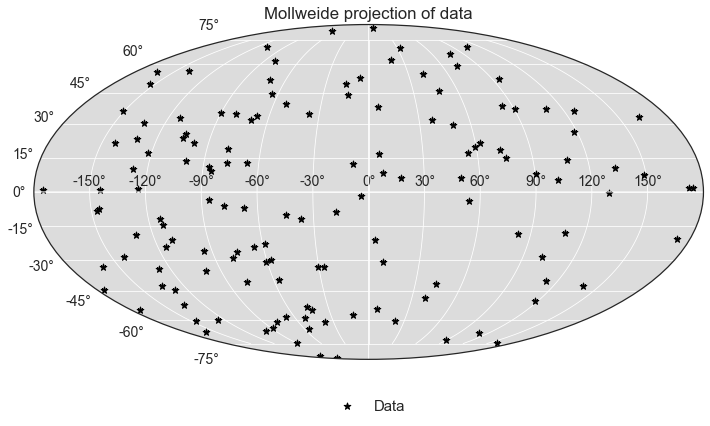

In [4]:
# Plot data
fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection': 'mollweide'})
aas.mollweide_projection(azi, zen, ax, title='Mollweide projection of data')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), prop={'size':15});

### Sample isotropic data

In [5]:
# sample same size isotropic data
N_points = len(data)
MC_azi, MC_zen = aas.sample_isotropic_data(seed=18, N_points=N_points)

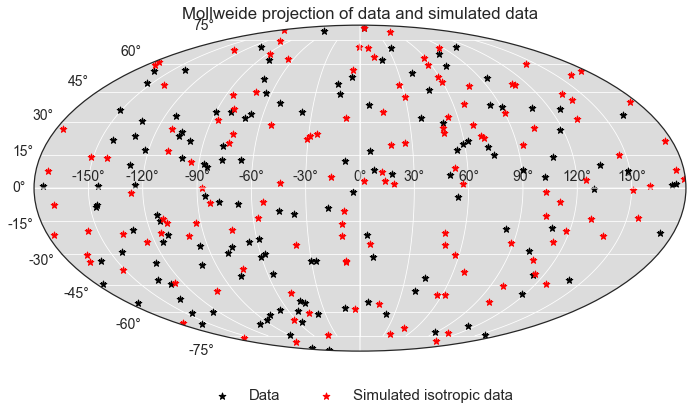

In [6]:
# Plot data and simulated sample
fig, ax = plt.subplots(figsize=(12,6), subplot_kw={'projection': 'mollweide'})

# Plot data
aas.mollweide_projection(azi, zen, ax, title='Mollweide projection of data and simulated data')

# Plot simulated sample
ax.scatter(MC_azi-np.pi, -MC_zen+np.pi/2, marker='*', color='r', s=50, zorder=2, label='Simulated isotropic data')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2, prop={'size':15})

plt.tight_layout()
if SaveFig:
    plt.savefig('Figs/2_1.pdf');

### Two Point Auto-Correlation Function

In [7]:
x, y, y_pred = aas.two_point_func(azi, zen)
MC_x, MC_y, MC_y_pred = aas.two_point_func(MC_azi, MC_zen)

### KS-test

In [8]:
KS_H0 = aas.KS_test(y, y_pred)
KS_MC_H0 = aas.KS_test(MC_y, MC_y_pred)
print(KS_H0, KS_MC_H0)

0.022574309673822568 0.0053196129875158205


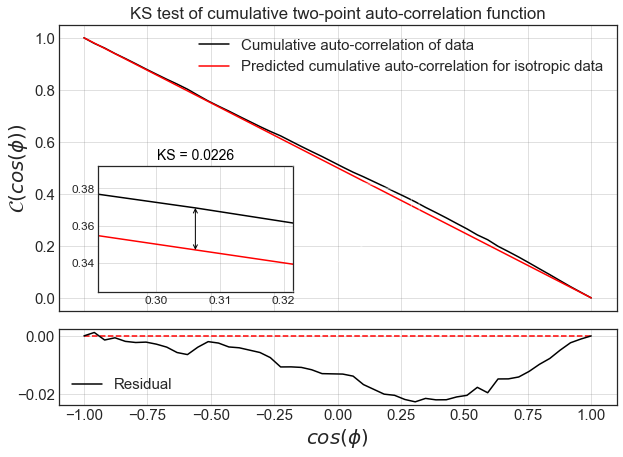

In [10]:
fig, ax = plt.subplots(nrows=2, figsize=(10,7), sharex=True, gridspec_kw = {'height_ratios': [1.5, 0.4], 'hspace': 0.1})
aas.KS_plot(x, y, y_pred, fig, ax)

if SaveFig:
    fig.savefig('Figs/2_2.pdf');

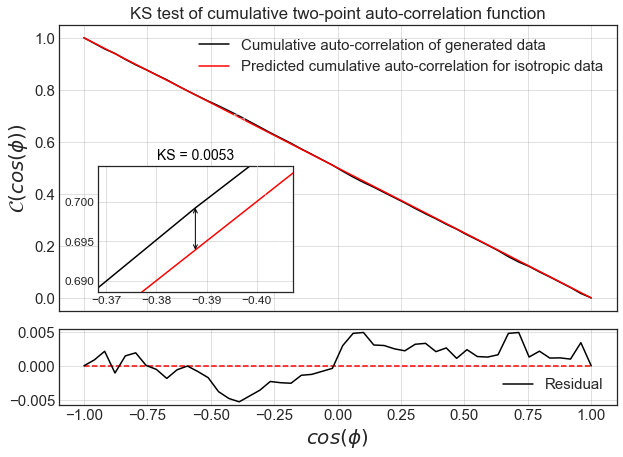

In [11]:
fig, ax = plt.subplots(nrows=2, figsize=(10,7), sharex=True, gridspec_kw = {'height_ratios': [1.5, 0.4], 'hspace': 0.1})
aas.KS_plot(MC_x, MC_y, MC_y_pred, fig, ax, 'Cumulative auto-correlation of generated data')


if SaveFig:
    fig.savefig('Figs/2_3.pdf');

### P-value from pseudo-experiments

In [12]:
# run pseudo experiments
N_experiments = 10000
KS_experiments = aas.sample_KS(N_experiments, len(azi))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
# calculate the p-value (integrating number of events above cut divided by events below)
p_iso = aas.compute_p_val(KS_H0, KS_experiments)
print(f'p-value for isotropic: {p_iso}')

p-value for isotropic: 0.0041


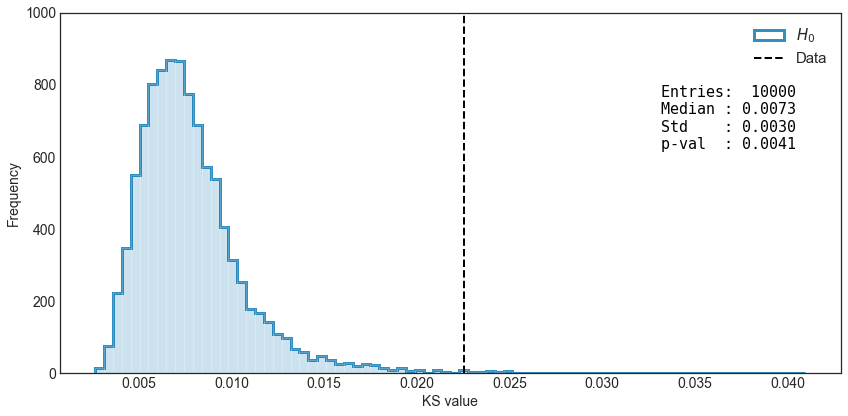

In [14]:
fig, ax = plt.subplots(figsize=(12,6))

# plot distribution of KS-values
bins_arr = np.arange(0,0.030,0.0005)
ax.hist(KS_experiments, color=color[0], histtype='step', alpha=0.8, linewidth=3, bins=80, zorder=2,
        label=r'$H_0$')
ax.hist(KS_experiments, color=color[0], alpha=0.2, bins=80, zorder=2)

# plot cut
ax.vlines(KS_H0, 0, 1000, color='k', lw=2, ls='--', zorder=3,label=f'Data')

# Display the pvalue and other specs
d = {r'Entries:': len(KS_experiments),
     r'Median :': np.median(KS_experiments),
     r'Std    :': np.std(KS_experiments),
     r'p-val  :': p_iso
    }
text = aas.nice_string_output(d, extra_spacing=1, decimals=4)
aas.add_text_to_ax(0.77, 0.8, text, ax, fontsize=15, color='k')

ax.legend(loc='upper right', prop={'size':15})
ax.set(xlabel='KS value', ylabel='Frequency', ylim=(0, 1000))

plt.tight_layout()

if SaveFig:
    plt.savefig('Figs/2_4.pdf')
    
plt.show()

## Problem 2B

### Define functions that sample the data according to the hypothesis stated

Code by Kimi Kreilgaard from https://github.com/KimiKreil/Advanced-Methods-in-Applied-Statistics. 

In [15]:
# Define a function to simulate data from hypothesis A
def sample_HA(seed, N_points=len(data)):
    
    # Set seed
    np.random.seed(seed)
    
    # Get number of points to sample uniformly in specified range
    N_uniform = int(0.2 * N_points)
    
    # Define uniform range
    uni_azim_range = (0.225*np.pi, 0.725*np.pi)
    uni_zeni_range = (0.30*np.pi, 1*np.pi)
    
    # Sample from uniform distributions within range
    uni_azim = np.random.uniform(*uni_azim_range, size=N_uniform)
    uni_zeni = np.random.uniform(*uni_zeni_range, size=N_uniform)
    
    # Sample the rest isotropically
    iso_azim = np.random.uniform(low=0, high=2*np.pi, size=N_points-N_uniform)
    iso_cos_zeni = np.random.uniform(low=-1, high=1, size=N_points-N_uniform)
    iso_zeni = np.arccos(iso_cos_zeni)
    
    # Concatenate arrays
    MC_azim = np.concatenate([uni_azim, iso_azim])
    MC_zeni = np.concatenate([uni_zeni, iso_zeni])
    
    return MC_azim, MC_zeni

# Define a function to simulate data from hypothesis B
def sample_HB(seed, N_points=len(data)):
    
    # Set seed
    np.random.seed(seed)
    
    # Get number of points to sample uniformly in specified range
    N_uniform = int(0.15 * N_points)
    
    # Define uniform range
    uni_azim_range = (0*np.pi, 1*np.pi)
    uni_zeni_range = (0.5*np.pi, 1*np.pi)
    
    # Sample from uniform distributions within range
    uni_azim = np.random.uniform(*uni_azim_range, size=N_uniform)
    uni_zeni = np.random.uniform(*uni_zeni_range, size=N_uniform)
    
    # Sample the rest isotropically
    iso_azim = np.random.uniform(low=0, high=2*np.pi, size=N_points-N_uniform)
    iso_cos_zeni = np.random.uniform(low=-1, high=1, size=N_points-N_uniform)
    iso_zeni = np.arccos(iso_cos_zeni)
    
    # Concatenate arrays
    MC_azim = np.concatenate([uni_azim, iso_azim])
    MC_zeni = np.concatenate([uni_zeni, iso_zeni])
    
    return MC_azim, MC_zeni

# Define a function that calculates the KS_test for many data sets simmulated from HA
def sample_KS_HA(N_samples, N_points):
    
    # Array to store KS val in
    KS_arr = []
    
    # Loop over samples
    print('------- SAMPLING HA -------')
    for i in tqdm(range(N_samples)):
    
        # Produce sample of isotropic data
        MC_azim, MC_zeni = sample_HA(i*100, N_points)
        
        # Get two point correlation func
        x, y, y_pred = aas.two_point_func(MC_azim, MC_zeni)
        
        # Get KS val
        KS_val = np.max( np.abs(y_pred-y) )
        KS_arr.append(KS_val)
        
    return KS_arr

# Define a function that calculates the KS_test for many data sets simmulated from HB
def sample_KS_HB(N_samples, N_points):
    
    # Array to store KS val in
    KS_arr = []
    
    # Loop over samples
    print('------- SAMPLING HB -------')
    for i in tqdm(range(N_samples)):
    
        # Produce sample of isotropic data
        MC_azim, MC_zeni = sample_HB(i*100, N_points)
        
        # Get two point correlation func
        x, y, y_pred = aas.two_point_func(MC_azim, MC_zeni)
        
        # Get KS val
        KS_val = np.max( np.abs(y_pred-y) )
        KS_arr.append(KS_val)
        
    return KS_arr

### Run 5000 pseudo experiments

In [16]:
# We produce 5000 experiments for each of the hypothesis (we already sampled isotropically)
N_experiments = 10000
KS_HA_experiments = sample_KS_HA(N_experiments, len(azi))
KS_HB_experiments = sample_KS_HB(N_experiments, len(azi))

------- SAMPLING HA -------


  0%|          | 0/10000 [00:00<?, ?it/s]

------- SAMPLING HB -------


  0%|          | 0/10000 [00:00<?, ?it/s]

### Calculate p values

In [17]:
# Calculate p-values with respect to isotropic data
p_iso_HA = aas.compute_p_val(np.median(KS_HA_experiments), KS_experiments)
p_iso_HB = aas.compute_p_val(np.median(KS_HB_experiments), KS_experiments)
print('is HA hypothesis compatible with isotropic sampling H0?')
print('p_iso_HA:', p_iso_HA)
print('is HB hypothesis compatible with isotropic sampling H0?')
print('p_iso_HB:', p_iso_HB)

print('------------------')

# Calculate p-values with respect to the real data
p_data_HA = aas.compute_p_val(KS_H0, KS_HA_experiments)
p_data_HB = aas.compute_p_val(KS_H0, KS_HB_experiments)
print('is HA hypothesis compatible with the data?')
print('p_data_HA:', p_data_HA)
print('is HB hypothesis compatible with the data')
print('p_data_HB:', p_data_HB)

is HA hypothesis compatible with isotropic sampling H0?
p_iso_HA: 0.012
is HB hypothesis compatible with isotropic sampling H0?
p_iso_HB: 0.0888
------------------
is HA hypothesis compatible with the data?
p_data_HA: 0.3205
is HB hypothesis compatible with the data
p_data_HB: 0.115


### Plot result

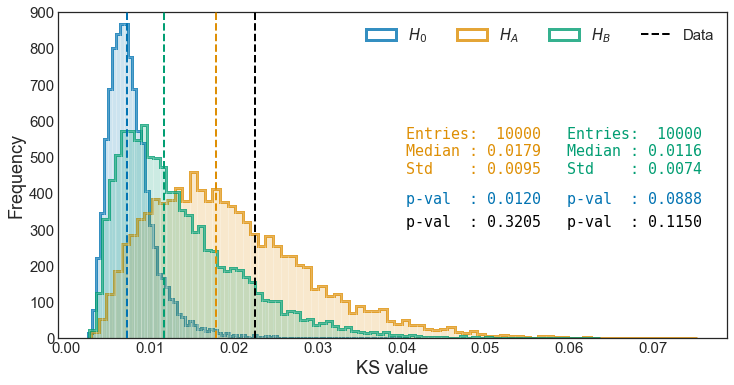

In [18]:
# Create figure to demonstrate the finding of the p-value
fig, ax = plt.subplots(figsize=(12,6))

y_max = 900

# Plot distribution of KS-values
bins_arr = np.arange(0,0.035,0.0005)
ax.hist(KS_experiments, color=color[0], histtype='step', alpha=0.8, linewidth=3, bins=80, zorder=2,
        label=r'$H_0$')
ax.hist(KS_experiments, color=color[0], alpha=0.2, bins=80, zorder=2)

ax.hist(KS_HA_experiments, color=color[1], histtype='step', alpha=0.8, linewidth=3, bins=80, zorder=2,
        label=r'$H_A$')
ax.hist(KS_HA_experiments, color=color[1], alpha=0.2, bins=80, zorder=2)

ax.hist(KS_HB_experiments, color=color[2], histtype='step', alpha=0.8, linewidth=3, bins=80, zorder=2,
        label=r'$H_B$')
ax.hist(KS_HB_experiments, color=color[2], alpha=0.2, bins=80, zorder=2)

# Plot the cut
ax.vlines(KS_H0, 0, y_max, color='k', linewidth=2, zorder=3, linestyle='dashed',
          label=f'Data')

# Mark medians
ax.vlines(np.median(KS_experiments), 0, y_max, color=color[0], linewidth=2, zorder=3, linestyle='dashed')
ax.vlines(np.median(KS_HA_experiments), 0, y_max, color=color[1], linewidth=2, zorder=3, linestyle='dashed')
ax.vlines(np.median(KS_HB_experiments), 0, y_max, color=color[2], linewidth=2, zorder=3, linestyle='dashed')


# Display the pvalue and other specs
d = {r'Entries:': len(KS_HA_experiments),
     r'Median :': np.median(KS_HA_experiments),
     r'Std    :': np.std(KS_HA_experiments),
    }
text = aas.nice_string_output(d, extra_spacing=1, decimals=4)
aas.add_text_to_ax(0.52, 0.65, text, ax, fontsize=15, color=color[1])

d = {r'p-val  :': p_iso_HA,
    }
text = aas.nice_string_output(d, extra_spacing=1, decimals=4)

aas.add_text_to_ax(0.52, 0.45, text, ax, fontsize=15, color=color[0])

d = {r'p-val  :': p_data_HA,
    }
text = aas.nice_string_output(d, extra_spacing=1, decimals=4)
aas.add_text_to_ax(0.52, 0.38, text, ax, fontsize=15, color='k')
# --------------------
d = {r'Entries:': len(KS_HB_experiments),
     r'Median :': np.median(KS_HB_experiments),
     r'Std    :': np.std(KS_HB_experiments),
    }
text = aas.nice_string_output(d, extra_spacing=1, decimals=4)
aas.add_text_to_ax(0.76, 0.65, text, ax, fontsize=15, color=color[2])

d = {r'p-val  :': p_iso_HB,
    }
text = aas.nice_string_output(d, extra_spacing=1, decimals=4)
aas.add_text_to_ax(0.76, 0.45, text, ax, fontsize=15, color=color[0])

d = {r'p-val  :': p_data_HB,
    }
text = aas.nice_string_output(d, extra_spacing=1, decimals=4)
aas.add_text_to_ax(0.76, 0.38, text, ax, fontsize=15, color='k')
# ------------------------

plt.ylim(0,y_max)
ax.legend(prop={'size':15}, ncol=4)
ax.set_xlabel('KS value', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

if SaveFig:
    plt.tight_layout()
    plt.savefig('Figs/2_4.pdf')
    
plt.show()